# Modelling V2

### This version of the Modelling pipeline is quite different from the previous iteration of the processing system.
### This version of the modelling system combines the feature extraction and the classifier model into one model. This is done by having the ResNet50 model as the backbone of the model, freezing the backbone ResNet50 model, and then replacing the final layers with our own Dense and Dropout layers.

The first step involves reading the CSV that contains all of the images that will be used for model creation.

In [1]:
import cv2
import pandas as pd

final_data_path = open("step1.txt", "r")
final_data_pre = pd.read_csv(final_data_path.read().strip())

In [2]:
final_data_pre

id           class_name  \
0     452f2473f3dd5817395dcaa16b58ab6e.png     banana_day1_self   
1     2da7e04b024ef07fd40e4f84213d6ca7.png     banana_day1_self   
2     708f00dd2a7c25d75680d18299d0254d.png     banana_day1_self   
3     866d7784b51be1f26a96af4c99e73448.png     banana_day1_self   
4     2e4fbf3ef0199cd4f664155171dbb849.png     banana_day1_self   
...                                    ...                  ...   
3821  2790a53203bb55d957f3d51eb8161592.png  avocado_firm_google   
3822  d8891a6e393c829c349241f4baac8ad5.png  avocado_firm_google   
3823  244c532e45a81497e3d51e81a1fcb04d.png  avocado_firm_google   
3824  8109576227fc9d3f8e5b74db76b4da70.png  avocado_firm_google   
3825  8d52aec527115a5fec609bab5c43d406.png  avocado_firm_google   

                                              file_path resolution  
0     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
1     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
2     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
3     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280  
4     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   1280x720  
...                                                 ...        ...  
3821  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    730x548  
3822  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    800x378  
3823  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    872x534  
3824  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    480x360  
3825  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    600x400  

[3826 rows x 4 columns]

The DataFrame format is generated by the createDerivation.py script, and the images were converted by the Paralells sub program.

After the dataframes are loaded, the next step is to make the training, testing, and validation splits of the data.

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
import optuna

def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img, label

def create_train_test_val_dfs(final_data_pre):
    
    label_processor = tf.keras.layers.StringLookup(
        output_mode='int', 
        vocabulary=final_data_pre['class_name'].unique(),
        num_oov_indices=0,
        mask_token=None 
    )
    number_of_classes = len(final_data_pre['class_name'].unique())
    train_and_tuning_df, val_df = train_test_split(
        final_data_pre, 
        test_size=0.15, 
        random_state=42, 
        stratify=final_data_pre['class_name']
    )
    train_df, test_df = train_test_split(
        train_and_tuning_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_and_tuning_df['class_name']
    )
    print(f"Train (Weights):    {len(train_df)}")
    print(f"Test  (Optuna):     {len(test_df)}")
    print(f"Val   (Final Eval): {len(val_df)}")
    return {
        "number_of_classes": number_of_classes,
        "label_processor": label_processor,
        "train_df": train_df,
        "test_df": test_df,
        "val_df": val_df
    }

2025-12-17 03:50:19.524745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The splitting ratio is 15% of the initial data is validation data, then of the remanining 85%, 80% is used for training and 20% is used for testing.    

After the data has been split, the next step is to create the tf.Data DataSets for each, in this case, this will also function as augmentation for the data to prevent the model from overfitting during training.

In [4]:
from tensorflow.keras import layers, Model, regularizers

def create_dses(input):
    # --- Configuration ---
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2), # Rotate +/- 20%
        layers.RandomZoom(0.2),     # Zoom in/out 20%
        layers.RandomTranslation(0.1, 0.1), # Shift image
        layers.RandomContrast(0.2), # Adjust contrast
        layers.RandomBrightness(0.2)
    ])

    def load_image(filepath, label):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        return img, label

    def create_dataset(df, is_training=True, batch_size=32):
        # Create source dataset
        ds = tf.data.Dataset.from_tensor_slices((df['file_path'].values, df['class_name'].values))
        ds = ds.map(lambda x, y: (x, input["label_processor"](y)))
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training:
            ds = ds.shuffle(buffer_size=1000)
            # We wrap augmentation in a lambda to ensure it runs correctly in graph mode
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    # Create the specific datasets
    train_ds = create_dataset(input["train_df"], is_training=True)
    test_ds  = create_dataset(input["test_df"], is_training=False)
    val_ds   = create_dataset(input["val_df"], is_training=False)
    return {
        "train_ds": train_ds,
        "number_of_classes": input["number_of_classes"],
        "test_ds": test_ds,
        "val_ds": val_ds
    }

The code block in this case only defines a function and doesnt actually do it to increase the modularity of the pipeline.

The next part is the model training function, which takes the training and testing datasets, and also the model name and number of traials to run for. For our training, Optuna is used to dynamically adjust the model's hyperparameters, unit size, and layer count, to optimize the objective of the model and that is to achieve a high score on the testing set.

In [5]:
%run modeldef4.py

def train_model(train_ds, test_ds, number_of_classes, model_name, number_of_trials):
    def objective(trial):
        # 1. Suggest Hyperparameters
        # Log scale is good for learning rates
        lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True) 
        
        # A. How many layers? (e.g., between 1 and 10)
        n_layers = trial.suggest_int('n_layers', 1, 10)
    
        # B. Define units for each layer dynamically
        layer_configs = []
        for i in range(n_layers):
            # We create a unique hyperparameter for each layer: "units_layer_0", "units_layer_1", etc.
            units = trial.suggest_int(f'units_layer_{i}', 32, 512, step=32)
            layer_configs.append(units)
        
        # Suggest dropout
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        epochs = trial.suggest_int("epochs", 5,20, step=1)
        
        # build the model
        model = DynamicResNetClassifier(
            num_classes=number_of_classes,
            layer_configs=layer_configs, # Pass the generated list
            dropout_rate=dropout
        )
        
        # compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
        # 4. Train with Pruning
        # The PruningCallback will stop unpromising trials early to save time
        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=epochs, # Short epochs for tuning (increase for final training)
            verbose=0, # Keep output clean
            callbacks=[optuna.integration.TFKerasPruningCallback(trial, 'val_accuracy')]
        )
        
        # Return the best validation accuracy of this trial
        return max(history.history['val_accuracy'])
    storage_name = "sqlite:///{}.db".format(model_name)

    study = optuna.create_study(
        study_name=model_name,
        storage=storage_name,  
        direction='maximize',
        load_if_exists=True    
    )

    print("Starting Hyperparameter Tuning for " + model_name + "....")
    study.optimize(objective, n_trials=number_of_trials)

    print("Best trial:")
    trial = study.best_trial

    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return study

The model's architecture is designed to be dynamically modifiable to make it tunable by Optuna.

This code block creates the final model training and validation datasets using the previously defined function.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def train_final_and_evaluate(study, train_ds, test_ds, val_ds, number_of_classes):
    best_params = study.best_trial.params
    print("Best Parameters Found:")
    print(best_params)
    best_layers = []
    for i in range(study.best_trial.params['n_layers']):
        best_layers.append(study.best_trial.params[f'units_layer_{i}'])

    # train the final BEST model with the BEST parameters
    final_model = DynamicResNetClassifier(
        num_classes=number_of_classes,
        layer_configs=best_layers, # Pass the generated list
        dropout_rate=best_params['dropout']
    )

    # Compile model with final learning rate
    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Final Training Run
    print("\nStarting Final Training...")
    history = final_model.fit(
        train_ds,
        validation_data=test_ds, 
        epochs=best_params['epochs'] + 5, # minor fudge factor for epochs
        verbose=1
    )

    # The Moment of Truth (Evaluation)
    # This is the ONLY time 'val_ds' is touched.
    print("\nRunning Final Evaluation on Hold-out Set (val_ds)...")
    test_loss, test_accuracy = final_model.evaluate(val_ds)

    print("="*40)
    print(f"FINAL UNBIASED ACCURACY: {test_accuracy * 100:.2f}%")
    print("="*40)
    return {
        "final_model": final_model,
        "history": history
    }

def visualize_predictions(dataset, model, label_processor, grid_rows=2, grid_cols=4):
    num_samples = grid_rows * grid_cols
    class_names = label_processor.get_vocabulary()
    correct_batch = {'imgs': [], 'true': [], 'pred': []}
    incorrect_batch = {'imgs': [], 'true': [], 'pred': []}

    print(f"Collecting {num_samples} correct and {num_samples} incorrect examples...")
    
    for images, labels in dataset:
        # Stop if we have enough of both
        if (len(correct_batch['imgs']) >= num_samples and 
            len(incorrect_batch['imgs']) >= num_samples):
            break

        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        
        images_np = images.numpy()
        labels_np = labels.numpy()
        preds_np = preds.numpy()
        
        for i in range(len(images_np)):
            if (len(correct_batch['imgs']) >= num_samples and 
                len(incorrect_batch['imgs']) >= num_samples):
                break
            
            true_idx = labels_np[i]
            pred_idx = preds_np[i]
            is_correct = (true_idx == pred_idx)
            
            target_dict = correct_batch if is_correct else incorrect_batch
            
            if len(target_dict['imgs']) < num_samples:
                target_dict['imgs'].append(images_np[i])
                target_dict['true'].append(class_names[true_idx])
                target_dict['pred'].append(class_names[pred_idx])

    # 2. Grid Plotting Logic
    def plot_grid(data_dict, title, color_code):
        count = len(data_dict['imgs'])
        if count == 0:
            print(f"No {title.lower()} predictions found.")
            return
        
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(3 * grid_cols, 3.5 * grid_rows))
        fig.suptitle(f"{title} Predictions", fontsize=20, color=color_code, weight='bold', y=1.02)
        axes_flat = axes.flatten() if count > 1 else [axes]
        
        for i in range(num_samples):
            ax = axes_flat[i]
            
            # if somehow the model is 100% accurate
            if i >= count:
                ax.axis('off')
                continue
            
            # Plot Image
            img = data_dict['imgs'][i].astype("uint8")
            ax.imshow(img)
            ax.axis("off")
            true_lab = data_dict['true'][i]
            pred_lab = data_dict['pred'][i]
            label_text = f"True: {true_lab}\nPred: {pred_lab}"
            ax.set_title(label_text, color='black', fontsize=11, pad=10)
            border_color = color_code
            plt.setp(ax.spines.values(), color=border_color, linewidth=2)

        plt.tight_layout()
        plt.show()

    # 3. Generate the two grids
    plot_grid(correct_batch, "Correct", "green")
    print("\n" + "="*50 + "\n")
    plot_grid(incorrect_batch, "Incorrect", "red")
    class_names = label_processor.get_vocabulary()
    
    # Containers
    correct_batch = {'imgs': [], 'true': [], 'pred': []}
    incorrect_batch = {'imgs': [], 'true': [], 'pred': []}
    for images, labels in dataset:
        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1) 
        images_np = images.numpy()
        labels_np = labels.numpy()
        preds_np = preds.numpy()
        
        for i in range(len(images_np)):
            # Check if we have collected enough of both types
            if (len(correct_batch['imgs']) >= num_samples and 
                len(incorrect_batch['imgs']) >= num_samples):
                break
            
            true_idx = labels_np[i]
            pred_idx = preds_np[i]
            
            # Helper to store data
            is_correct = (true_idx == pred_idx)
            target_dict = correct_batch if is_correct else incorrect_batch
            
            # Only append if we haven't reached the limit for this type
            if len(target_dict['imgs']) < num_samples:
                target_dict['imgs'].append(images_np[i])
                target_dict['true'].append(class_names[true_idx])
                target_dict['pred'].append(class_names[pred_idx])

        if (len(correct_batch['imgs']) >= num_samples and 
            len(incorrect_batch['imgs']) >= num_samples):
            break

    def plot_row(data_dict, title, color):
        count = len(data_dict['imgs'])
        if count == 0:
            print(f"No {title.lower()} predictions found to display.")
            return

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"{title} Predictions", fontsize=16, color=color, weight='bold')
        
        for i in range(count):
            plt.subplot(1, count, i + 1)
            img = data_dict['imgs'][i].astype("uint8")
            plt.imshow(img)
            plt.axis("off")
            
            # Title: True vs Pred
            true_lab = data_dict['true'][i]
            pred_lab = data_dict['pred'][i]
            
            label_text = f"True: {true_lab}\nPred: {pred_lab}"
            plt.title(label_text, color=color, fontsize=10)
        plt.show()

    # show the correct predictions
    plot_row(correct_batch, "Correct", "green")
    # show the incorrect predictions
    plot_row(incorrect_batch, "Incorrect", "red")

The code below creates the final models for avocados, bananas, and a combined model.

## Avocado Testing & Evaluation

In [28]:

# Train avocado only model
avocado_only = final_data_pre[final_data_pre["class_name"].str.contains("avocado")]
step1avc = create_train_test_val_dfs(avocado_only)
step2avc = create_dses(step1avc)

Train (Weights):    2368
Test  (Optuna):     592
Val   (Final Eval): 523


In [14]:
study_avc = train_model(step2avc["train_ds"],step2avc["test_ds"], step2avc["number_of_classes"], "avocado_only", 15)

[I 2025-12-17 01:41:54,841] A new study created in RDB with name: avocado_only


Starting Hyperparameter Tuning for avocado_only....


2025-12-17 01:42:12.346693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 16 bytes spill stores, 16 bytes spill loads

[I 2025-12-17 01:44:26,829] Trial 0 finished with value: 0.9611486196517944 and parameters: {'learning_rate': 0.0003841132660376857, 'n_layers': 1, 'units_layer_0': 256, 'dropout': 0.42562633394568494, 'epochs': 17}. Best is trial 0 with value: 0.9611486196517944.
2025-12-17 01:44:38.058915: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 01:44:38.058961: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the 

Best trial:
  Value: 0.9679054021835327
  Params: 
    learning_rate: 0.00025257771877811545
    n_layers: 1
    units_layer_0: 512
    dropout: 0.2416849208592094
    epochs: 20


In [32]:
storage_name = "sqlite:///{}.db".format("avocado_only")

study = optuna.create_study(
    study_name="avocado_only",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_avc = study

[I 2025-12-17 04:33:00,880] Using an existing study with name 'avocado_only' instead of creating a new one.


In [33]:
avc_results = train_final_and_evaluate(study_avc, step2avc["train_ds"],step2avc["test_ds"], step2avc["val_ds"], step2avc["number_of_classes"])


Best Parameters Found:
{'learning_rate': 0.00025257771877811545, 'n_layers': 1, 'units_layer_0': 512, 'dropout': 0.2416849208592094, 'epochs': 20}

Starting Final Training...
Epoch 1/25


2025-12-17 04:33:13.304906: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 04:33:13.895885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5226', 20 bytes spill stores, 20 bytes spill loads

2025-12-17 04:33:14.541564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5559', 520 bytes spill stores, 520 bytes spill loads

2025-12-17 04:33:14.557179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5559', 4 b

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5631 - loss: 1.1096

2025-12-17 04:33:24.341151: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 16 bytes spill stores, 16 bytes spill loads



74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7090 - loss: 0.7551 - val_accuracy: 0.8851 - val_loss: 0.3418
Epoch 2/25
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8704 - loss: 0.3397 - val_accuracy: 0.9189 - val_loss: 0.2735
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9117 - loss: 0.2540 - val_accuracy: 0.9037 - val_loss: 0.2512
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9219 - loss: 0.2114 - val_accuracy: 0.9257 - val_loss: 0.1991
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9253 - loss: 0.1997 - val_accuracy: 0.9054 - val_loss: 0.2425
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9434 - loss: 0.1570 - val_accuracy: 0.9527 - val_loss: 0.1750
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9459 - loss: 0.1519 - val_accuracy: 0.9527 - val_loss: 0.1523
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9396 - loss: 0.1566 - val_accuracy: 0.9409 -

In [ ]:
visualize_predictions(
    step2avc["val_ds"],
    avc_results["final_model"],
    step1avc["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

## Banana Testing & Evaluation

In [29]:

# Train banana only model
banana_only = final_data_pre[final_data_pre["class_name"].str.contains("banana")]
step1banan = create_train_test_val_dfs(banana_only)
step2banan = create_dses(step1banan)

Train (Weights):    232
Test  (Optuna):     59
Val   (Final Eval): 52


In [ ]:
study_banana = train_model(step2banan["train_ds"],step2banan["test_ds"], step2banan["number_of_classes"], "banana_only", 15)

[I 2025-12-17 01:38:14,581] Using an existing study with name 'banana_only' instead of creating a new one.


Starting Hyperparameter Tuning for banana_only....


2025-12-17 01:38:22.312660: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 01:38:22.312702: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 01:38:22.312733: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 01:38:22.312773: I external/l

Best trial:
  Value: 0.7627118825912476
  Params: 
    learning_rate: 0.00048639902050737064
    n_layers: 2
    units_layer_0: 352
    units_layer_1: 224
    dropout: 0.28152177037003634
    epochs: 17


In [34]:
storage_name = "sqlite:///{}.db".format("banana_only")

study = optuna.create_study(
    study_name="banana_only",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_banana = study

[I 2025-12-17 04:36:54,962] Using an existing study with name 'banana_only' instead of creating a new one.


In [35]:
banana_results = train_final_and_evaluate(study_banana, step2banan["train_ds"],step2banan["test_ds"], step2banan["val_ds"], step2banan["number_of_classes"])

Best Parameters Found:
{'learning_rate': 0.00048639902050737064, 'n_layers': 2, 'units_layer_0': 352, 'units_layer_1': 224, 'dropout': 0.28152177037003634, 'epochs': 17}

Starting Final Training...
Epoch 1/22


2025-12-17 04:37:05.834240: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 04:37:05.834268: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 04:37:06.162503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5650', 16 bytes spill stores, 16 bytes spill loads

2025-12-17 04:37:06.427811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.1954 - loss: 2.4620

2025-12-17 04:37:19.102490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 56 bytes spill stores, 56 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1983 - loss: 2.2666 - val_accuracy: 0.4407 - val_loss: 1.6218
Epoch 2/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3190 - loss: 1.8635 - val_accuracy: 0.4576 - val_loss: 1.5287
Epoch 3/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3621 - loss: 1.6635 - val_accuracy: 0.5424 - val_loss: 1.2472
Epoch 4/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4440 - loss: 1.3323 - val_accuracy: 0.5932 - val_loss: 1.1230
Epoch 5/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4784 - loss: 1.2242 - val_accuracy: 0.5763 - val_loss: 1.0537
Epoch 6/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5474 - loss: 1.1034 - val_accuracy: 0.6441 - val_loss: 0.9430
Epoch 7/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5733 - loss: 1.0048 - val_accuracy: 0.6102 - val_loss: 0.8819
Epoch 8/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6681 - loss: 0.8946 - val_accuracy: 0.6610 - val_loss: 0.8534
Epoch 9/22
8

2025-12-17 04:37:43.526976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 56 bytes spill stores, 56 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7692 - loss: 0.5492  
FINAL UNBIASED ACCURACY: 76.92%


In [26]:
visualize_predictions(
    step2banan["val_ds"],
    banana_results["final_model"],
    step1banan["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

2025-12-16 15:22:24.367781: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.00MiB (rounded to 51380224)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-16 15:22:24.368460: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-12-16 15:22:24.368485: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 3674, Chunks in use: 3673. 918.5KiB allocated for chunks. 918.2KiB in use in bin. 266.0KiB client-requested in use in bin.
2025-12-16 15:22:24.368490: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 1237, Chunks in use: 1236. 631.2KiB allocated for chunks. 630.8KiB in use in bin. 618.4KiB client-requested in use i

ResourceExhaustedError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[32,28,28,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(32, 28, 28, 128), dtype=float32)

## Combined Model Testing & Evaluation

In [7]:

# Train banana only model
all_in_one = final_data_pre
step1aio = create_train_test_val_dfs(all_in_one)
step2aio = create_dses(step1aio)

I0000 00:00:1765943431.054632  113092 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Train (Weights):    2601
Test  (Optuna):     651
Val   (Final Eval): 574


In [8]:
study_aio = train_model(step2aio["train_ds"],step2aio["test_ds"], step2aio["number_of_classes"], "all_in_one", 2)

[I 2025-12-17 02:36:16,687] Using an existing study with name 'all_in_one' instead of creating a new one.


Starting Hyperparameter Tuning for all_in_one....


2025-12-17 02:36:24.194274: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fec5c015fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 02:36:24.194297: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-17 02:36:24.499225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 02:36:25.649942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-17 02:36:25.897138: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 02:36:25.897197: I e

Best trial:
  Value: 0.9431643486022949
  Params: 
    learning_rate: 0.0003570309537250524
    n_layers: 2
    units_layer_0: 320
    units_layer_1: 64
    dropout: 0.14100539843029325
    epochs: 16


In [8]:
storage_name = "sqlite:///{}.db".format("all_in_one")

study = optuna.create_study(
    study_name="all_in_one",
    storage=storage_name,  
    direction='maximize',
    load_if_exists=True    
)
study_aio = study

[I 2025-12-17 03:50:34,216] Using an existing study with name 'all_in_one' instead of creating a new one.


In [9]:
aio_results = train_final_and_evaluate(study_aio, step2aio["train_ds"],step2aio["test_ds"], step2aio["val_ds"], step2aio["number_of_classes"])

Best Parameters Found:
{'learning_rate': 0.0003570309537250524, 'n_layers': 2, 'units_layer_0': 320, 'units_layer_1': 64, 'dropout': 0.14100539843029325, 'epochs': 16}

Starting Final Training...
Epoch 1/21


2025-12-17 03:50:42.984098: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fc7cc0026a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 03:50:42.984121: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-17 03:50:43.267089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 03:50:44.379790: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-17 03:50:44.585007: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 03:50:44.585055: I e

 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.1528 - loss: 3.1321 

I0000 00:00:1765943450.992193  113460 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4704 - loss: 1.6886

2025-12-17 03:51:03.875107: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 03:51:04.111930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733', 8 bytes spill stores, 8 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - accuracy: 0.6025 - loss: 1.1877 - val_accuracy: 0.7988 - val_loss: 0.5387
Epoch 2/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7724 - loss: 0.6024 - val_accuracy: 0.8479 - val_loss: 0.3825
Epoch 3/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8304 - loss: 0.4478 - val_accuracy: 0.8694 - val_loss: 0.3624
Epoch 4/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8404 - loss: 0.3948 - val_accuracy: 0.8817 - val_loss: 0.2902
Epoch 5/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.8727 - loss: 0.3238 - val_accuracy: 0.8909 - val_loss: 0.2818
Epoch 6/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8889 - loss: 0.2817 - val_accuracy: 0.8602 - val_loss: 0.3150
Epoch 7/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9004 - loss: 0.2636 - val_accuracy: 0.9109 - val_loss: 0.2292
Epoch 8/21
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9097 - loss: 0.2411 - val_accuracy: 0.9063 - val_loss: 

2025-12-17 03:54:09.321772: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 03:54:09.895633: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 52 bytes spill stores, 52 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.8589 - loss: 0.3702
FINAL UNBIASED ACCURACY: 85.89%


In [ ]:
visualize_predictions(
    step2aio["val_ds"],
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

## Extended Combined Model Testing

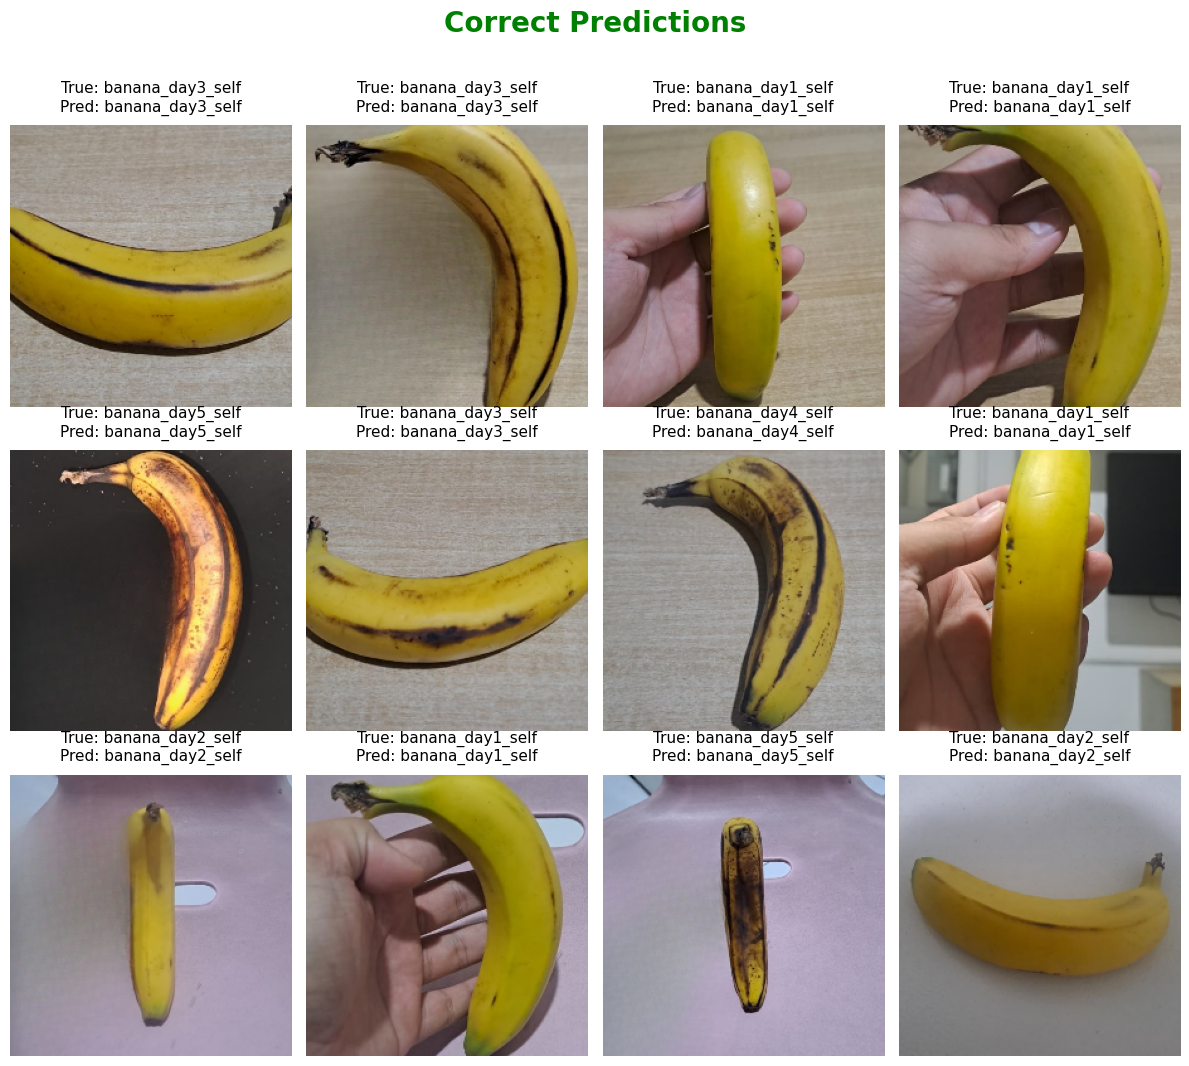

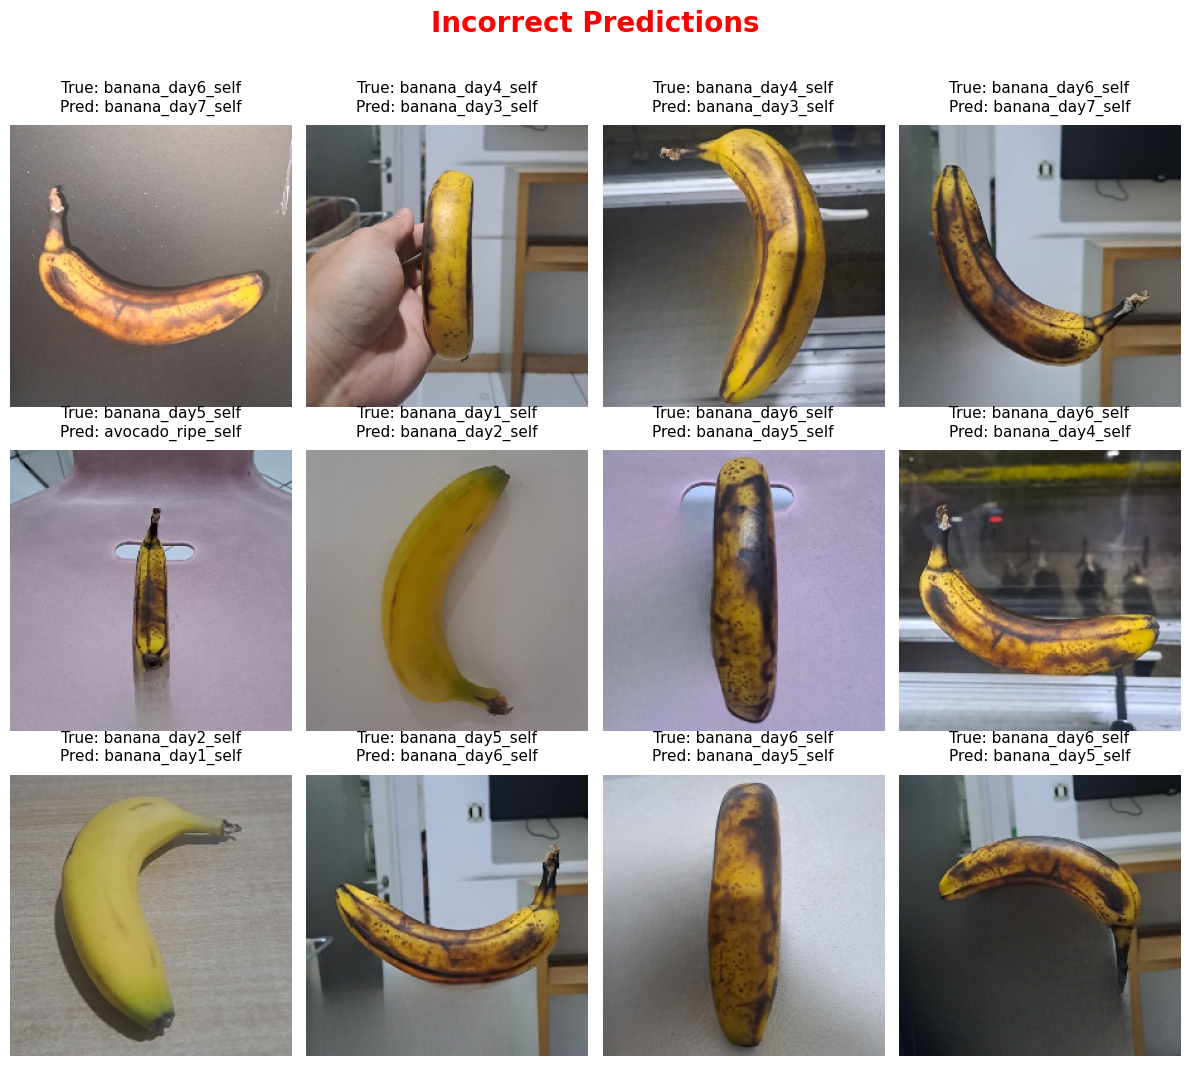

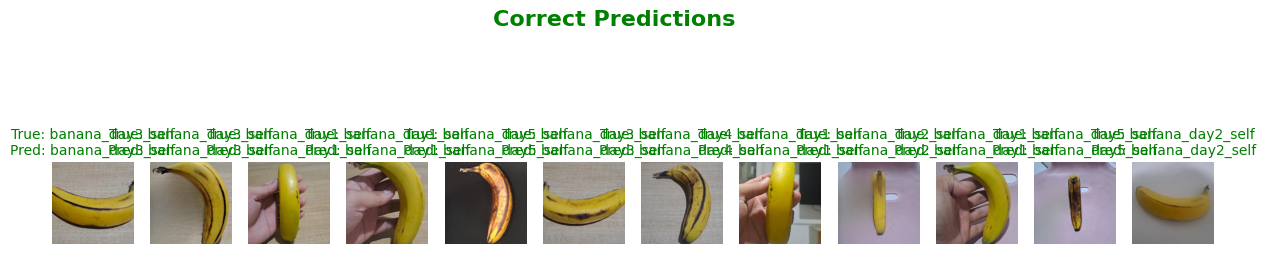

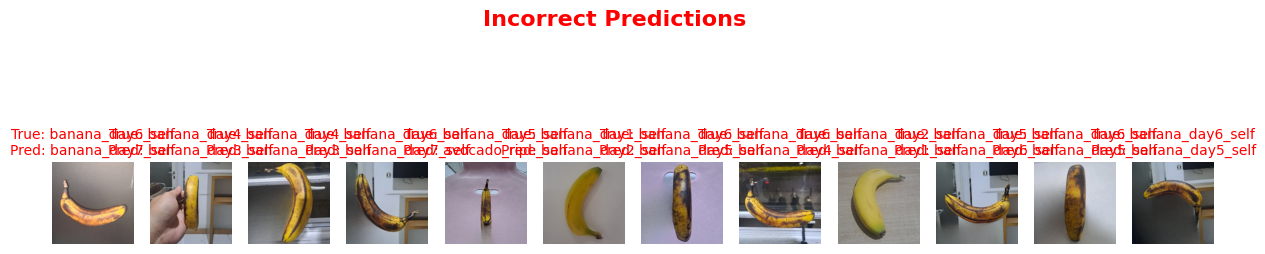

In [ ]:
indexes = final_data_pre.class_name.unique()

# Filter val_df to only banana classes
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("banana")]

# Build a tf.data.Dataset for banana-only samples (no shuffle/augmentation)
aio_val_ds_avocado = tf.data.Dataset.from_tensor_slices(
    (avocado_val_df["file_path"].values, avocado_val_df["class_name"].values)
)
aio_val_ds_avocado = aio_val_ds_avocado.map(
    lambda x, y: (x, step1aio["label_processor"](y))
)
aio_val_ds_avocado = aio_val_ds_avocado.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
aio_val_ds_avocado = aio_val_ds_avocado.batch(32).prefetch(tf.data.AUTOTUNE)
visualize_predictions(
    aio_val_ds_avocado,
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

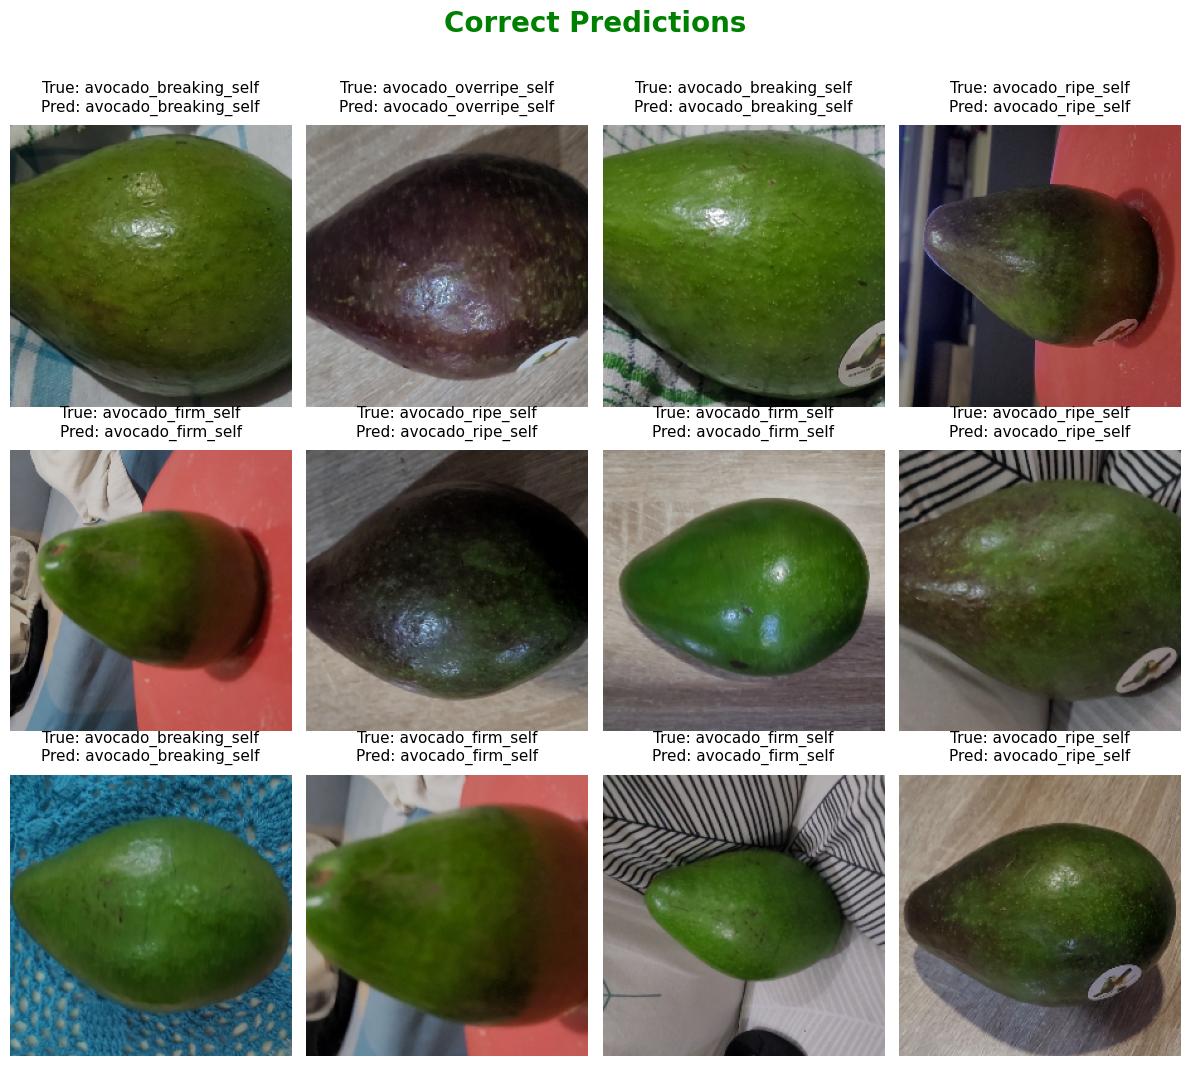

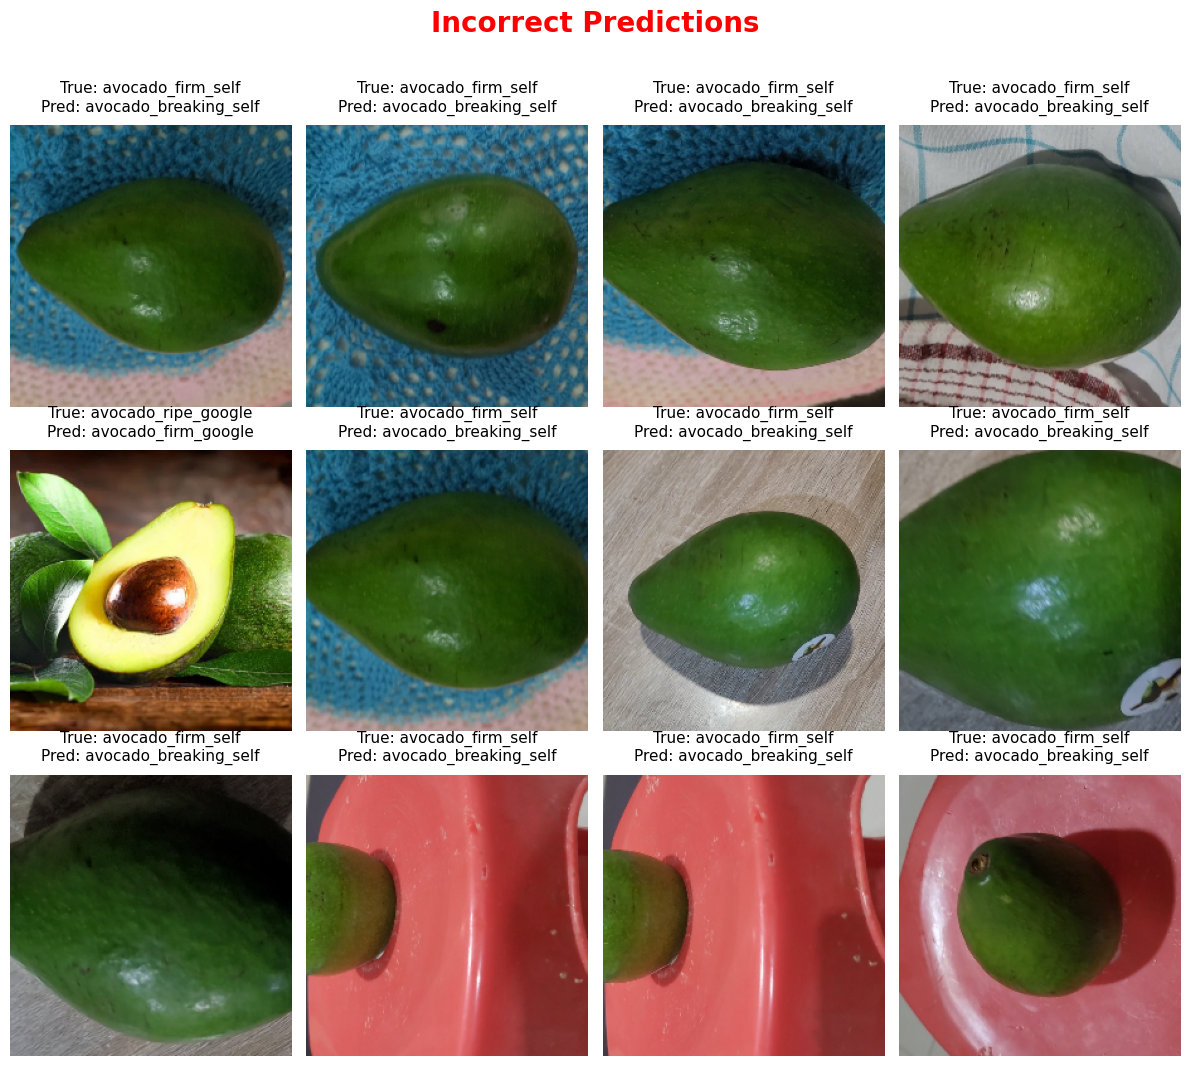

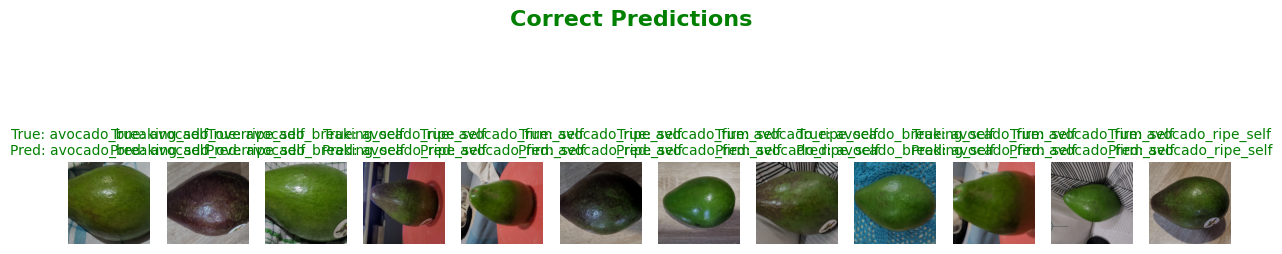

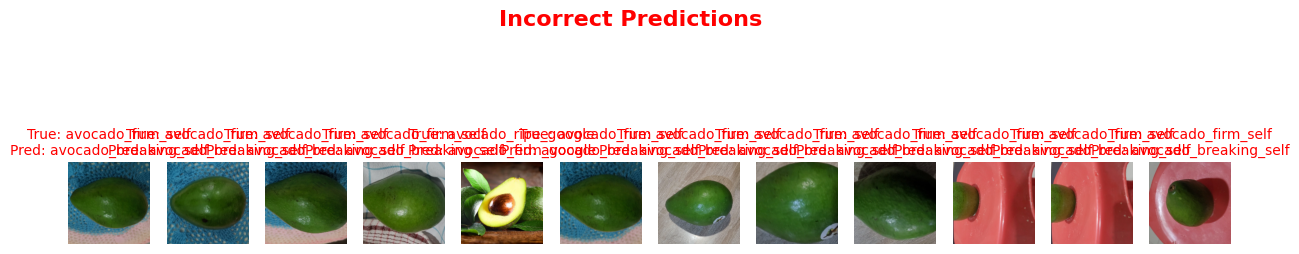

In [26]:
indexes = final_data_pre.class_name.unique()

# Filter val_df to only banana classes
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("avocado")]

# Build a tf.data.Dataset for banana-only samples (no shuffle/augmentation)
aio_val_ds_avocado = tf.data.Dataset.from_tensor_slices(
    (avocado_val_df["file_path"].values, avocado_val_df["class_name"].values)
)
aio_val_ds_avocado = aio_val_ds_avocado.map(
    lambda x, y: (x, step1aio["label_processor"](y))
)
aio_val_ds_avocado = aio_val_ds_avocado.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
aio_val_ds_avocado = aio_val_ds_avocado.batch(32).prefetch(tf.data.AUTOTUNE)
visualize_predictions(
    aio_val_ds_avocado,
    aio_results["final_model"],
    step1aio["label_processor"],
    grid_rows=3,  # Adjust rows here
    grid_cols=4   # Adjust columns here
)

In [36]:
# ...existing code...

# Build avocado-only eval sets for both models
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("avocado")]

aio_val_avocado = (
    tf.data.Dataset.from_tensor_slices((avocado_val_df["file_path"].values,
                                        avocado_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

avc_val_avocado = (
    tf.data.Dataset.from_tensor_slices((avocado_val_df["file_path"].values,
                                        avocado_val_df["class_name"].values))
    .map(lambda x, y: (x, step1avc["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

# Build banana-only eval sets for both models
banana_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("banana")]

aio_val_banana = (
    tf.data.Dataset.from_tensor_slices((banana_val_df["file_path"].values,
                                        banana_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

ban_val_banana = (
    tf.data.Dataset.from_tensor_slices((banana_val_df["file_path"].values,
                                        banana_val_df["class_name"].values))
    .map(lambda x, y: (x, step1banan["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

# Evaluate
print("Avocado subset:")
_, acc_combined_avc = aio_results["final_model"].evaluate(aio_val_avocado, verbose=0)
_, acc_avc_only    = avc_results["final_model"].evaluate(avc_val_avocado, verbose=0)
print(f"  Combined model: {acc_combined_avc*100:.2f}%")
print(f"  Avocado-only  : {acc_avc_only*100:.2f}%")

print("\nBanana subset:")
_, acc_combined_ban = aio_results["final_model"].evaluate(aio_val_banana, verbose=0)
_, acc_ban_only     = banana_results["final_model"].evaluate(ban_val_banana, verbose=0)
print(f"  Combined model: {acc_combined_ban*100:.2f}%")
print(f"  Banana-only   : {acc_ban_only*100:.2f}%")
# ...existing code...

Avocado subset:
  Combined model: 86.81%
  Avocado-only  : 91.97%

Banana subset:


2025-12-17 04:38:39.942632: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 04:38:40.543950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 52 bytes spill stores, 52 bytes spill loads

2025-12-17 04:38:44.522242: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 56 bytes spill stores, 56 bytes spill loads



  Combined model: 76.47%
  Banana-only   : 86.27%
